In [21]:
import keras
from keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X = pd.read_csv('X.csv', index_col=0)
Y = pd.read_csv('Y.csv', index_col=0)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

# Transpose the dataset
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train =np.array(y_train)
y_test = np.array(y_test)

In [23]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [24]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - loss: 25.1583 - mean_absolute_error: 4.8658 - val_loss: 3.4976 - val_mean_absolute_error: 1.5615
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - loss: 2.8930 - mean_absolute_error: 1.3448 - val_loss: 1.4213 - val_mean_absolute_error: 0.8733
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - loss: 2.4948 - mean_absolute_error: 1.2326 - val_loss: 1.4174 - val_mean_absolute_error: 0.8713
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - loss: 2.4128 - mean_absolute_error: 1.1805 - val_loss: 1.3849 - val_mean_absolute_error: 0.8713
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - loss: 2.3068 - mean_absolute_error: 1.1708 - val_loss: 1.4344 - val_mean_absolute_error: 0.8686
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 2.2677 - mean_absolute_error: 1.1661 - val_loss: 1.4006 - val_mean_absolute_error: 0.8628
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - loss: 2.2276 - mean_absolute_error: 1.1610 

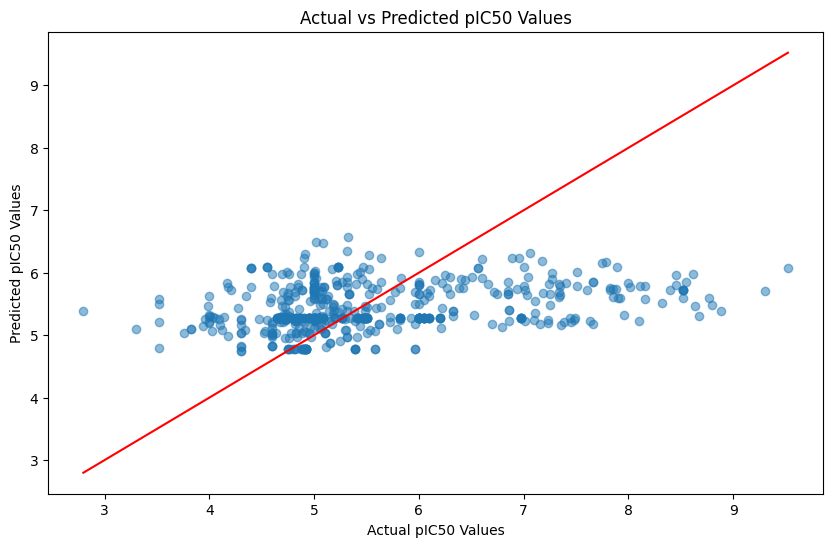

In [25]:
input_shape = (885, 1)
head_size = 64
num_heads = 1
ff_dim= 64
num_transformer_blocks = 1
mlp_units=[128, 64]
mlp_dropout=0.4
dropout=0.25


model = build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout,
    mlp_dropout,
)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Assume X_train and y_train are already defined and preprocessed
X_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
X_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Mean Absolute Error: {mae}')

# Make predictions
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual pIC50 Values')
plt.ylabel('Predicted pIC50 Values')
plt.title('Actual vs Predicted pIC50 Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of equality
plt.show()